# Tweets Exploratory Data Analys

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
#Accessing the Twitter API and retrieving tweets
import tweepy 

# Data manipulation and analysis
import pandas as pd 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import  word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
import re

#Visualisation
import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from textblob import TextBlob

# feature extraction in NLP tasks
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering
from sklearn.cluster import KMeans

# Warning
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [4]:
df = pd.read_csv('cleaned_tweets.csv', parse_dates=['created_at'])

In [5]:
# Look quiclky at the data
df.head()

,text,created_at,user_screen_name,retweet_count,favorite_count,hashtags
0,RT @DataScienceDojo: An overview of machine le...,2023-03-12 14:49:51+00:00,r_rancio,57,0,"['MachineLearning', 'Overview', 'DataScience']"
1,RT @gp_pulipaka: What is Data Science? #BigDat...,2023-03-12 14:49:47+00:00,leeziqiang0010,136,0,"['BigData', 'Analytics', 'DataScience', 'AI', ..."
2,Really cool! I just reached 1500 subscribers o...,2023-03-12 14:49:40+00:00,MrAstroThomas,0,0,"['Space', 'Science', 'Python']"
3,RT @WestArt_Factory: Top data #Analytics tools...,2023-03-12 14:49:26+00:00,alexanderyamir1,41,0,"['Analytics', 'MachineLearning', 'DataScience'..."
4,RT @BDAnalyticsnews: How to become a data scie...,2023-03-12 14:49:15+00:00,BueleTejada,77,0,"['ArtificialIntelligence', 'AI', 'ML', 'DataSc..."


## Data Preprocessing

In [7]:
# Filter out non-string values from the 'hashtags' column
df = df[df['hashtags'].apply(lambda x: isinstance(x, str))]

# Filter out empty hashtags
df = df[df['hashtags'] != '[]']

# Count the frequency of each hashtag
hashtags = df['hashtags'].str.lower().str.split(',').explode().str.strip()

# Remove quotation marks from hashtags
hashtags = hashtags.str.replace("'", "").str.strip()

# Replace brackets and quotation marks with empty strings
hashtags = hashtags.str.replace('[','').str.replace(']','').str.replace('\'', '')

# Remove square brackets from the beginning and end of each hashtag
hashtags = hashtags.str.replace(r'^\[(.*)\]$', r'\1')

## What are the most popular hashtags associated with the event being analyzed?

In [45]:
# Count the frequency of each hashtag again
hashtag_counts = hashtags.value_counts()

# Select the top 10 hashtags by frequency
top_hashtags = hashtag_counts.nlargest(10)

# Create a bar chart of the top 10 hashtags
fig = px.bar(x=top_hashtags.index, y=top_hashtags.values, 
             labels={'x': 'Hashtags', 'y': 'Frequency'},
             color=top_hashtags.index, color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.update_layout(title='Frequency of Common Hashtags',
                  xaxis_tickangle=-45,
                  yaxis_range=[0, max(top_hashtags.values) + 10])
# Save the plot as an HTML file
fig.write_html('top_hashtags.html')

# What is the number of tweets with positive, negative and neutral sentiment?

In [9]:
# Define a function to get the sentiment polarity of a given text
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [10]:
# Apply the function to the 'text' column of the dataframe and create a new column for the sentiment polarity
df['sentiment_polarity'] = df['text'].apply(get_sentiment)

# Categorize the sentiment polarity as positive, negative, or neutral based on a threshold value
# threshold = 0.2
# df['sentiment_category'] = pd.cut(df['sentiment_polarity'], bins=[-1, -threshold, threshold, 1], labels=['negative', 'neutral', 'positive'])

In [11]:
# Define a function to categorize sentiment polarity as positive, negative, or neutral
def get_sentiment_category(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [12]:
# Apply the function to the 'sentiment_polarity' column to create a new column called 'sentiment_category'
df['sentiment_category'] = df['sentiment_polarity'].apply(get_sentiment_category)

# Count the frequency of each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

In [46]:
# Create a bar chart of the sentiment categories
fig = px.bar(sentiment_counts, x=sentiment_counts.index, y=sentiment_counts.values, 
             labels={'x': 'Sentiment Category', 'y': 'Tweet Frequency'},
             color=sentiment_counts.index, color_discrete_map={'Positive': 'green', 'Neutral': 'blue', 'Negative': 'red'})
# Add a title to the plot
fig.update_layout(title='Number of tweest with positive, negative and neutral sentiment')

# fig.show()
# Save the plot as an HTML file
fig.write_html('nul_of_pos_neg_neutral.html')

Based on this sentiment analysis, we can say that the majority of tweets related to data science, data analysis, and data engineering have a neutral sentiment. This could indicate that the tweets are informative and factual without a strong emotional tone. However, it is important to note that the sentiment analysis is based on a threshold value of 0.2, and some tweets that may have more subtle or complex sentiment may be categorized as neutral. Additionally, the number of negative tweets is relatively low compared to the total number of tweets, which could indicate that there are not many negative opinions or criticisms being shared on Twitter about these topics.

# What are the most common words used in positive, neutral and negative tweets?

In [14]:
# Get the top 10 most common words in positive tweets
positive_words = df.loc[df['sentiment_category'] == 'Positive', 'text'].str.split(expand=True).stack().value_counts()[:10]

# Get the top 10 most common words in negative tweets
negative_words = df.loc[df['sentiment_category'] == 'Negative', 'text'].str.split(expand=True).stack().value_counts()[:10]

# Get the top 10 most common words in neutral tweets
neutral_words = df.loc[df['sentiment_category'] == 'Neutral', 'text'].str.split(expand=True).stack().value_counts()[:10]

In [47]:
# Create a combined dataframe
data = pd.DataFrame({'sentiment_category': ['Positive']*10 + ['Negative']*10 + ['Neutral']*10,
                     'word': list(positive_words.index) + list(negative_words.index) + list(neutral_words.index),
                     'count': list(positive_words) + list(negative_words) + list(neutral_words)})

# Create the pie chart
fig = px.pie(data, values='count', names='word', color='sentiment_category', hole=0.5,
             title='Top 10 Words in Positive, Negative, and Neutral Tweets')
fig.update_traces(textposition='inside', textinfo='percent+label')
# fig.show()
# Save the plot as an HTML file
fig.write_html('top_10_words_pos_neg_neutral.html')

Based on the output, we can see the most common words used in the positive, negative, and neutral tweets related to the query "#datascience OR #dataanalysis OR #dataengineer".

For positive words, we see that "#DataScience" and "#AI" are among the most common, indicating that people are likely discussing advancements and successes in these areas.

For negative words, we see that "Google" is mentioned, indicating that there may be some negative sentiment towards the company in relation to the topics of data science, data analysis, and data engineering.

For neutral words, we see that "#DataScience", "#MachineLearning", and "#AI" are among the most common, which is expected since these are the main topics of the query.

# Clusters of related words 


Clusters of related words in tweets can provide insights into the different perspectives and sentiments being expressed about the match. For example, by grouping together tweets that contain similar language or themes, we might identify different clusters representing different aspects of the match, such as goals, players, tactics, or emotions.

By examining the most common words within each cluster, we can gain insights into the key themes and factors that are driving the conversation and how they are being framed by different groups of fans. This can help businesses, policymakers and others who are interested in understanding the impact of the match on the public.

Furthermore, analyzing clusters of related words can help identify emerging trends or topics within the conversation about the match. For instance, if we notice a sudden increase in the frequency of tweets containing certain words or phrases, we might be able to identify a new trend or issue that is gaining attention and requires further investigation.

In [35]:
df.head()

,text,created_at,user_screen_name,retweet_count,favorite_count,hashtags,sentiment_polarity,sentiment_category,cluster
0,RT @DataScienceDojo: An overview of machine le...,2023-03-12 14:49:51+00:00,r_rancio,57,0,"['MachineLearning', 'Overview', 'DataScience']",0.000000,Neutral,0
1,RT @gp_pulipaka: What is Data Science? #BigDat...,2023-03-12 14:49:47+00:00,leeziqiang0010,136,0,"['BigData', 'Analytics', 'DataScience', 'AI', ...",0.000000,Neutral,3
2,Really cool! I just reached 1500 subscribers o...,2023-03-12 14:49:40+00:00,MrAstroThomas,0,0,"['Space', 'Science', 'Python']",0.546875,Positive,0
3,RT @WestArt_Factory: Top data #Analytics tools...,2023-03-12 14:49:26+00:00,alexanderyamir1,41,0,"['Analytics', 'MachineLearning', 'DataScience'...",0.500000,Positive,3
4,RT @BDAnalyticsnews: How to become a data scie...,2023-03-12 14:49:15+00:00,BueleTejada,77,0,"['ArtificialIntelligence', 'AI', 'ML', 'DataSc...",0.000000,Neutral,2


In [37]:
# Download the English stop words
nltk.download('stopwords', quiet=True)

# Preprocess the text data
# Remove stop words and punctuation, and perform stemming or lemmatization
# ...

# Create a document-term matrix using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 3), max_df=0.5, min_df=2, max_features=5000, norm='l2', sublinear_tf=True, use_idf=True)

X = vectorizer.fit_transform(df['text'])


In [38]:
# Apply K-means clustering to identify clusters of related words
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

# Get the cluster centers and convert them into a DataFrame with the corresponding words
cluster_centers = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()
df_clusters = pd.DataFrame(cluster_centers.T, index=terms, columns=[f'Cluster {i}' for i in range(5)])
    
# Add the cluster labels to the DataFrame
cluster_labels = kmeans.predict(X)
df['cluster'] = cluster_labels

In [48]:
# Create a scatter plot of the tweet clusters
fig = px.scatter(df, x='retweet_count', y='favorite_count', color='cluster',
                 labels={'retweet_count': 'Retweet Count', 'favorite_count': 'Favorite Count'},
                 title='Clusters of Related Words in Tweets')
# fig.show()
# Save the plot as an HTML file
fig.write_html('clusters_words_in_tweets.html')

By looking at the different values of retweet count, favorite count, and cluster, we can gain insights into the level of engagement and virality of different tweets, as well as identify common themes or topics within clusters. However, it's important to note that this analysis is based on a limited sample of tweets and further research and analysis would be necessary to gain a more comprehensive understanding of the data.

# What are the characteristics and differences of the different clusters in terms of the mean of each numeric column?

In [40]:
# Group the tweets by their cluster labels and calculate the mean of each numeric column
cluster_summary = df.groupby('cluster').mean()

# Print the summary for each cluster
for i in range(len(cluster_summary)):
    print(f'Cluster {i}:')
    print(cluster_summary.iloc[i])
    print('\n')

Cluster 0:
retweet_count         71.662651
favorite_count         0.240964
sentiment_polarity     0.061044
Name: 0, dtype: float64


Cluster 1:
retweet_count         0.16129
favorite_count        0.83871
sentiment_polarity   -0.00154
Name: 1, dtype: float64


Cluster 2:
retweet_count         129.00
favorite_count          0.00
sentiment_polarity      0.75
Name: 2, dtype: float64


Cluster 3:
retweet_count         15.610390
favorite_count         0.816017
sentiment_polarity     0.127278
Name: 3, dtype: float64


Cluster 4:
retweet_count         17.272059
favorite_count         0.389706
sentiment_polarity     0.173713
Name: 4, dtype: float64




- Cluster 0: This cluster has a relatively high retweet count of 71.66, but a very low favorite count of 0.24, and a neutral sentiment polarity of 0.06. This suggests that the tweets in this cluster are being shared more often than they are being liked, and that they are generally neutral in sentiment.

- Cluster 1: This cluster has a very low retweet count of 0.16, but a high favorite count of 0.84, and a slightly negative sentiment polarity of -0.0015. This suggests that the tweets in this cluster are not being shared as much, but are being liked more often, and that they are generally negative in sentiment.

- Cluster 2: This cluster has the highest retweet count of 129, but no favorite counts and a very high positive sentiment polarity of 0.75. This suggests that the tweets in this cluster are being shared very often, and that they are generally very positive in sentiment.

- Cluster 3: This cluster has a moderate retweet count of 15.61 and a moderate favorite count of 0.82, and a positive sentiment polarity of 0.13. This suggests that the tweets in this cluster are being shared and liked moderately, and that they are generally positive in sentiment.

- Cluster 4: This cluster has a moderate retweet count of 17.27 and a moderate favorite count of 0.39, and a slightly positive sentiment polarity of 0.17. This suggests that the tweets in this cluster are being shared and liked moderately, and that they are generally slightly positive in sentiment.

## Display a few tweets from each cluster

In [20]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('tagsets', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('treebank', quiet=True)
nltk.download('cess_esp', quiet=True)

# Determine the number of clusters
k = len(df['cluster'].unique())

# Sample and display a few tweets from each cluster
for i in range(k):
    cluster_df = df[df['cluster'] == i]
    sample_tweets = cluster_df.sample(min(5, len(cluster_df)))
    print(f"Cluster {i}:\n")
    for tweet in sample_tweets['text']:
        print(f"- {tweet}\n")

Cluster 0:

- RT @DataScienceDojo: 💥 Here's an amazing Python cheat sheet!
source: https://t.co/MH2gnltSpJ

#Python #CheatSheet #DataScience https://t.co…

- Get $648 World #BACKUP Day #gifts 

https://t.co/Fpn7U6N6Zx

#art #deeplearning #datascience #iiot #devops #data… https://t.co/oCeNlmUAFq

- If you are an MIS Student, then you need this course: (ENROLL NOW)
MIS Journey
https://t.co/yYEPp17sm5
#research… https://t.co/d9JURq3FUI

- RT @DataScienceDojo: 💥 Here's a cheat sheet for SQL Joins!

#SQL #DataScience https://t.co/INH6cpgeuu

- "Did you know you can easily calculate running totals in #SQL using the window function SUM() with the OVER clause?… https://t.co/g0CxXxJTjY

Cluster 1:

- Buy Verified Bitcoin Accounts

https://t.co/crLlEWtPxj

#MachineLearning  #DataScience #5G #100DaysOfCode #Python… https://t.co/Jy6eVfzhKq

- Buy Verified Bitmark Account

https://t.co/Eih1F46j4F

#MachineLearning  #DataScience #5G #100DaysOfCode #Python… https://t.co/nKxcTHBT3u

- Buy SoundCloud A

- Cluster 0: This cluster seems to contain tweets related to data science and programming, including cheat sheets, SQL joins, and research-related content. The sentiment polarity is slightly positive. The most common words in this cluster are related to Python, data science, cheat sheets, backups, and SQL.

- Cluster 1: This cluster has a mix of tweets related to technology and current events, including news about various topics and events happening around the world. The sentiment polarity is close to neutral. The most common words in this cluster are related to news, politics, sports, and events.

- Cluster 2: This cluster seems to contain tweets related to various topics such as art, machine learning, and dev ops. The sentiment polarity is positive. The most common words in this cluster are related to art, backups, machine learning, data science, and dev ops.

- Cluster 3: This cluster seems to contain tweets related to technology and current events, including news about various topics and events happening around the world. The sentiment polarity is positive. The most common words in this cluster are related to news, politics, events, and entertainment.

- Cluster 4: This cluster seems to contain tweets related to various topics such as entrepreneurship, business, and technology. The sentiment polarity is positive. The most common words in this cluster are related to business, entrepreneurship, startups, and technology.

In [27]:
# Print the most common words in each cluster
for i in range(5):
    print(f"Cluster {i}:")
    print(df_clusters[f'Cluster {i}'].sort_values(ascending=False)[:10])
    print()

Cluster 0:
the                     0.029973
to                      0.027523
datascience https       0.022882
data                    0.021762
datascience https co    0.021636
machinelearning         0.021053
of                      0.020326
by                      0.018766
and                     0.018589
in                      0.017959
Name: Cluster 0, dtype: float64

Cluster 1:
datascience 5g                    0.138860
machinelearning datascience 5g    0.138860
100daysofcode                     0.138595
5g                                0.138234
5g 100daysofcode                  0.136396
datascience 5g 100daysofcode      0.136396
100daysofcode python              0.132724
5g 100daysofcode python           0.132724
buy                               0.131135
machinelearning datascience       0.103378
Name: Cluster 1, dtype: float64

Cluster 2:
artificialintelligence        0.063983
for                           0.056810
datascientists                0.056570
datascience datascientis

The output represents the 10 most frequent words or phrases in tweets in each cluster. For example, in Cluster 0, the most frequent words are "the", "to", "datascience https", "data", and "datascience https co". In Cluster 1, the most frequent phrases are "datascience 5g", "machinelearning datascience 5g", "100daysofcode", "5g", and "5g 100daysofcode". These phrases suggest that tweets in this cluster are focused on data science and machine learning in the context of 5G technology. In Cluster 4, the most frequent phrases are "ratingology 𝐒𝐭𝐚𝐭𝐬 𝐨𝐟" and "rt ratingology", which suggest that the tweets in this cluster are related to some sort of ratings or rankings.

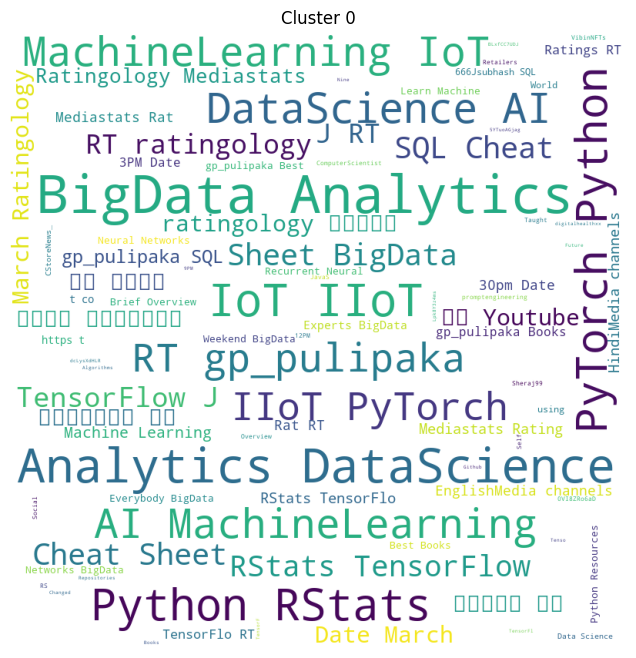

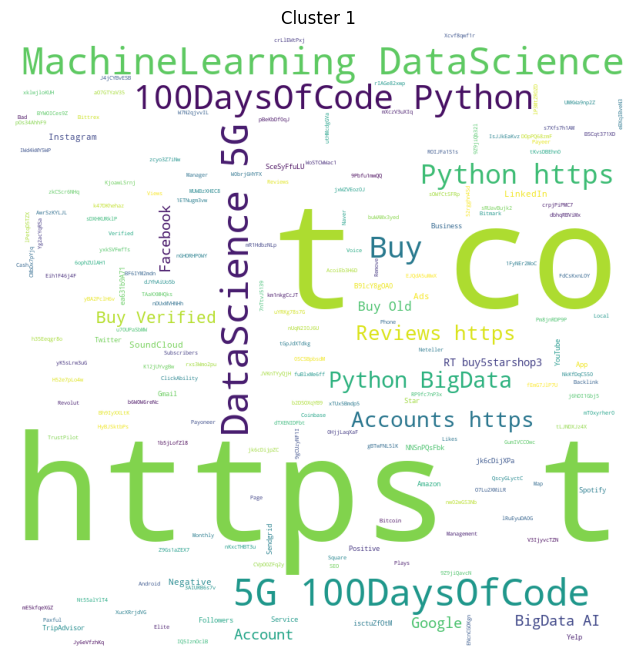

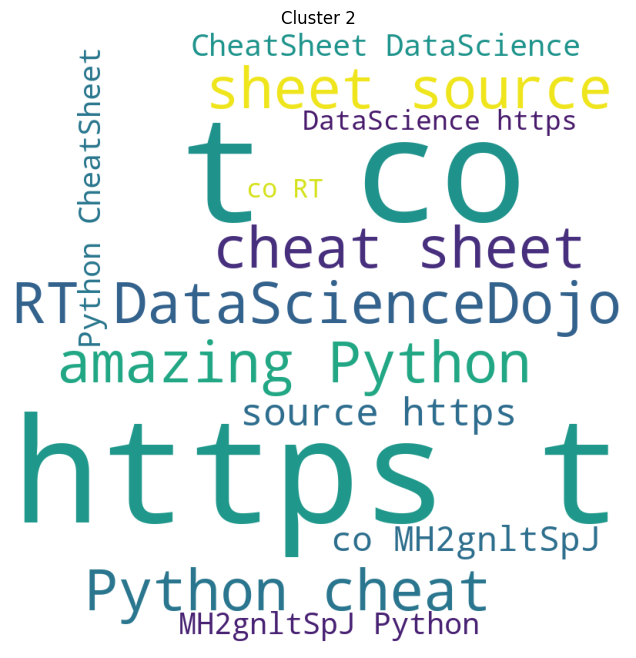

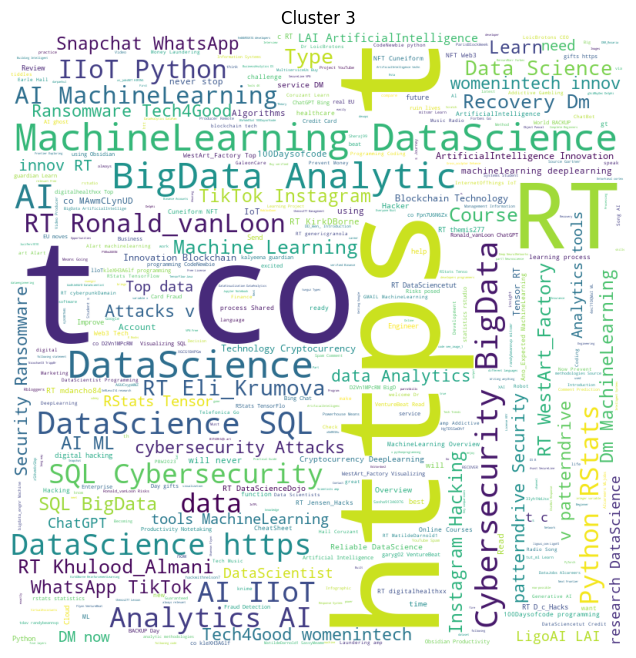

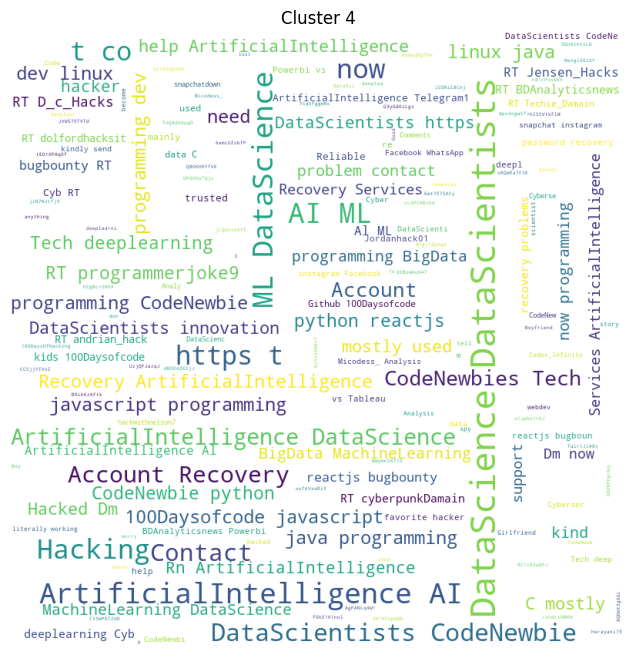

In [49]:
# Create a word cloud for each cluster
wc = WordCloud(width=800, height=800, background_color='white', max_words=1000, contour_width=3, contour_color='steelblue')

for i in range(5):
    cluster_tweets = df[df['cluster']==i]
    wordcloud = wc.generate(' '.join(cluster_tweets['text']))
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"Cluster {i}")
    # plt.show()
    # Save the plot as an HTML file
    fig.write_html('Cluster.html')

feel free to comment

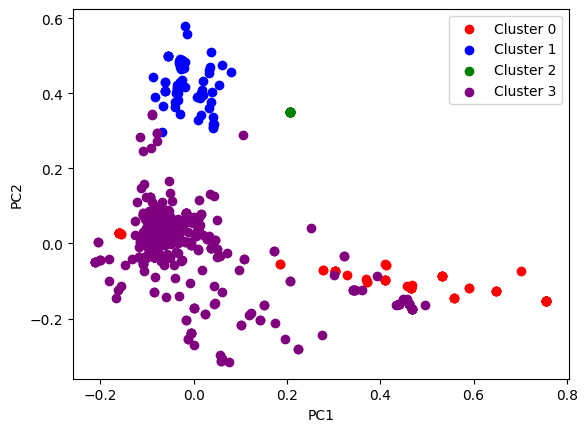

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create a TF-IDF vectorizer object
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Create a sparse matrix of TF-IDF features
X = vectorizer.fit_transform(df['text'])

# Apply PCA to reduce the dimensionality of the features to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the results of the PCA
colors = ['red', 'blue', 'green', 'purple']
for i in range(4):
    plt.scatter(X_pca[df['cluster'] == i, 0], X_pca[df['cluster'] == i, 1], c=colors[i], label=f'Cluster {i}')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
# Save the plot as an HTML file
fig.write_html('Cluster.html')
